In [271]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Initialize drawing utilities for pose visualization
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def detect_and_visualize_pose(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose detection
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        print("No pose landmarks detected.")
        return

    # Create a copy of the image to draw landmarks and connections
    annotated_image = image.copy()

    # Draw landmarks and connections on the image
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=3),  # Customize landmark style
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)   # Customize connection style
    )

    # Convert the image back to RGB for matplotlib
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Display the annotated image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image_rgb)
    plt.title('Pose Estimation with Landmarks and Connections')
    plt.axis('off')
    plt.show()



# Example usage
image_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames_sequences/Screenshot 2024-09-17 at 10.20.04.png' 
detect_and_visualize_pose(image_path)


Error: Could not load image.


I0000 00:00:1726633994.865641 1407578 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro
[ WARN:0@421233.426] global loadsave.cpp:241 findDecoder imread_('/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames_sequences/Screenshot 2024-09-17 at 10.20.04.png'): can't open/read file: check file path/integrity


In [272]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load YOLO model
def load_yolo():
    path_to_cfg = "/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg"
    path_to_weights = "/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    
    # Handling different versions of OpenCV which may return different formats
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers

# Perform YOLO detection on an image
def yolo_detect(net, image, output_layers, confidence_threshold=0.3):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:  # Person class
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))

    # Select the largest box if boxes were detected
    if boxes:
        largest_box = max(boxes, key=lambda b: b[2] * b[3])  # b[2]*b[3] is the area of the box (w*h)
        largest_confidence = confidences[boxes.index(largest_box)]
        return [largest_box], [largest_confidence]
    return [], []  # Return empty lists if no boxes detected

In [273]:
# Initialize MediaPipe Pose Estimation
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Extract pose landmarks from the cropped image
def extract_pose_landmarks(cropped_img):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    
    # Perform pose detection
    results = pose.process(image_rgb)

    # If landmarks are detected
    if results.pose_landmarks:
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y, landmark.z])
        return np.array(landmarks).flatten()
    return None

I0000 00:00:1726633994.936747 1407578 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro


In [274]:
# Calculate step length between left and right ankles
def calculate_step_length(pose_sequence):
    left_ankle_x, left_ankle_y = pose_sequence[27*3], pose_sequence[27*3 + 1]  # left ankle
    right_ankle_x, right_ankle_y = pose_sequence[28*3], pose_sequence[28*3 + 1]  # right ankle
    step_length = np.linalg.norm(np.array([right_ankle_x, right_ankle_y]) - np.array([left_ankle_x, left_ankle_y]))
    return step_length

# Calculate joint velocities between two consecutive frames
def calculate_velocity(pose_sequence_t, pose_sequence_t1, joint_index):
    joint_t = np.array([pose_sequence_t[joint_index*3], pose_sequence_t[joint_index*3 + 1]])
    joint_t1 = np.array([pose_sequence_t1[joint_index*3], pose_sequence_t1[joint_index*3 + 1]])
    velocity = np.linalg.norm(joint_t1 - joint_t)
    return velocity

# Calculate joint angles (hip-knee-ankle)
def calculate_joint_angle(pose_sequence, hip_idx, knee_idx, ankle_idx):
    hip = np.array([pose_sequence[hip_idx*3], pose_sequence[hip_idx*3 + 1]])
    knee = np.array([pose_sequence[knee_idx*3], pose_sequence[knee_idx*3 + 1]])
    ankle = np.array([pose_sequence[ankle_idx*3], pose_sequence[ankle_idx*3 + 1]])
    
    # Calculate vectors
    vec_hip_knee = knee - hip
    vec_knee_ankle = ankle - knee
    
    # Calculate the cosine of the angle between the vectors
    cos_angle = np.dot(vec_hip_knee, vec_knee_ankle) / (np.linalg.norm(vec_hip_knee) * np.linalg.norm(vec_knee_ankle))
    angle = np.arccos(cos_angle)
    return np.degrees(angle)

In [275]:
# Function to calculate temporal features (step length, velocity, joint angles)
def calculate_features(pose_landmarks, previous_landmarks=None):
    frame_features = [0] * 5  # Five features (step length, velocity x2, joint angles x2)

    # Step Length
    step_length = calculate_step_length(pose_landmarks)
    frame_features[0] = step_length

    # Joint Velocities (use previous landmarks if available)
    if previous_landmarks is not None:
        left_ankle_velocity = calculate_velocity(previous_landmarks, pose_landmarks, 27)
        right_ankle_velocity = calculate_velocity(previous_landmarks, pose_landmarks, 28)
        frame_features[1] = left_ankle_velocity
        frame_features[2] = right_ankle_velocity

    # Joint Angles (hip-knee-ankle)
    left_leg_angle = calculate_joint_angle(pose_landmarks, 23, 25, 27)
    right_leg_angle = calculate_joint_angle(pose_landmarks, 24, 26, 28)
    frame_features[3] = left_leg_angle
    frame_features[4] = right_leg_angle

    return frame_features

In [276]:
def load_and_preprocess_data(root_folder, net, output_layers):
    features = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            previous_landmarks = None
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None or img.size == 0:
                        print(f"Failed to load image {img_path}.")
                        continue

                    # Detect player using YOLO
                    boxes, _ = yolo_detect(net, img, output_layers)

                    for box in boxes:
                        x, y, w, h = box
                        if w > 0 and h > 0:  # Check if box dimensions are valid
                            cropped_img = img[y:y+h, x:x+w]

                            # Extract pose landmarks using MediaPipe Pose
                            pose_landmarks = extract_pose_landmarks(cropped_img)
                            if pose_landmarks is not None:
                                # Extract temporal features (step length, velocity, joint angles)
                                frame_features = calculate_features(pose_landmarks, previous_landmarks)
                                
                                # Store current landmarks as previous for velocity calculation
                                previous_landmarks = pose_landmarks

                                # Append frame features (fixed length)
                                features.append(frame_features)
                                labels.append(player_name)  # Append player name as label

    if not features:
        print("No valid images or features found in dataset.")
        return np.array([]), np.array([]), None  # Return empty arrays if no data
    
    features = np.array(features, dtype=np.float32)  # Ensure consistent data type

    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    return features, encoded_labels, encoder


In [277]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Group features by player
def group_features_by_player(features, labels):
    grouped_data = {}
    
    for feature_set, label in zip(features, labels):
        if label not in grouped_data:
            grouped_data[label] = []
        grouped_data[label].append(feature_set)
    
    return grouped_data

# Create sequences from grouped features
def create_sequences(grouped_data, sequence_length=10):
    sequences = []
    labels = []
    
    for label, features in grouped_data.items():
        # Generate sequences of features for each player
        for i in range(len(features) - sequence_length + 1):
            sequence = features[i:i + sequence_length]
            sequences.append(sequence)
            labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Prepare the data for LSTM
def prepare_lstm_data(features, labels, sequence_length=10):
    # Group the features by player
    grouped_data = group_features_by_player(features, labels)
    
    # Create sequences of features
    sequences, labels = create_sequences(grouped_data, sequence_length)
    
    # Reshape the sequences to the format (samples, timesteps, features)
    sequences = sequences.reshape((sequences.shape[0], sequence_length, -1))  # -1 to handle multiple features
    
    return sequences, labels


W0000 00:00:1726633994.972470 2372553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [278]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
def build_lstm_model(sequence_length, num_features, num_classes):

    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


# def build_hypermodel(hp):
#     model = Sequential()
    
#     # Tune the number of units in the LSTM layer
#     lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
#     model.add(LSTM(lstm_units, input_shape=(sequence_length, num_features),
#                    kernel_regularizer=l2(hp.Float('l2_reg', 1e-5, 1e-3, sampling='log'))))
    
#     # Tune the dropout rate
#     dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
#     model.add(Dropout(dropout_rate))
    
#     # Tune the dense layer size
#     dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
#     model.add(Dense(dense_units, activation='relu',
#                     kernel_regularizer=l2(hp.Float('l2_reg_dense', 1e-5, 1e-3, sampling='log'))))
    
#     model.add(Dropout(dropout_rate))  # Dropout layer after dense
    
#     # Output layer
#     model.add(Dense(num_classes, activation='softmax'))
    
#     # Tune the learning rate
#     learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     return model

In [279]:
# Function to apply moving average smoothing
def smooth_curve(points, factor=0.5):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Function to plot accuracy and loss curves with smoothing
def plot_training_history(history, smoothing_factor=0.5):
    # Apply smoothing to accuracy and loss values
    acc = smooth_curve(history.history['accuracy'], smoothing_factor)
    val_acc = smooth_curve(history.history['val_accuracy'], smoothing_factor)
    loss = smooth_curve(history.history['loss'], smoothing_factor)
    val_loss = smooth_curve(history.history['val_loss'], smoothing_factor)

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Function to display the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to display the classification report
def print_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes)
    print('Classification Report:')
    print(report)

W0000 00:00:1726633994.990411 2372553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [280]:
# import keras_tuner as kt

# # Example Usage
# output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
# net, output_layers = load_yolo()  # Load YOLO model
# features, labels, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers)  # Load and preprocess data

# sequence_length = 10  # Define the sequence length (number of frames per sequence)

# # Prepare the LSTM data (features grouped into sequences)
# lstm_sequences, lstm_labels = prepare_lstm_data(features, labels, sequence_length)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(lstm_sequences, lstm_labels, test_size=0.2, random_state=42)

# # Each sequence now has multiple features
# print(f"Training data shape: {X_train.shape}")
# print(f"Testing data shape: {X_test.shape}")

# # Initialize the model
# num_features = X_train.shape[2]  # Automatically detect the number of features (step length, velocity, angles, etc.)
# num_classes = len(encoder.classes_)  # Number of players

# # Initialize Keras Tuner
# tuner = kt.Hyperband(
#     build_hypermodel,
#     objective='val_accuracy',
#     max_epochs=50,
#     factor=3,
#     directory='my_tuner_results',
#     project_name='lstm_hyperparameter_tuning'
# )

# # Add early stopping to the training process
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Perform the hyperparameter tuning search
# tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

# # Get the best hyperparameters and model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.hypermodel.build(best_hps)

# # Summary of the best hyperparameters
# print(f"Best LSTM units: {best_hps.get('lstm_units')}")
# print(f"Best Dropout rate: {best_hps.get('dropout_rate')}")
# print(f"Best Dense units: {best_hps.get('dense_units')}")
# print(f"Best L2 regularization (LSTM): {best_hps.get('l2_reg')}")
# print(f"Best L2 regularization (Dense): {best_hps.get('l2_reg_dense')}")
# print(f"Best Learning rate: {best_hps.get('learning_rate')}")

# # Train the best model again
# history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), 
#                          callbacks=[early_stopping])

# # Evaluate the model
# train_loss, train_acc = best_model.evaluate(X_train, y_train)
# print(f"Train accuracy: {train_acc}")
# test_loss, test_acc = best_model.evaluate(X_test, y_test)
# print(f"Test accuracy: {test_acc}")

# # Plot training history (accuracy and loss)
# plot_training_history(history)

# # Make predictions
# y_pred = best_model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Plot confusion matrix
# plot_confusion_matrix(y_test, y_pred_classes, encoder.classes_)

# # Print classification report
# print_classification_report(y_test, y_pred_classes, encoder.classes_)


# Best LSTM units: 128
# Best Dropout rate: 0.2
# Best Dense units: 32
# Best L2 regularization (LSTM): 0.0009739977915931193
# Best L2 regularization (Dense): 0.0003818085074245017
# Best Learning rate: 0.00401517670583821

W0000 00:00:1726633995.015660 2372577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1726633995.033136 2372582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


/Users/pubudusenarathne/Library/Python/3.9/lib/python/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Extracted features shape: (727, 5)
Number of labels: 727
Training data shape: (538, 10, 5)
Testing data shape: (135, 10, 5)
Epoch 1/50


/Users/pubudusenarathne/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1494 - loss: 1.9289 - val_accuracy: 0.2148 - val_loss: 1.7809
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1428 - loss: 1.8396 - val_accuracy: 0.2148 - val_loss: 1.7723
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2041 - loss: 1.7790 - val_accuracy: 0.2148 - val_loss: 1.7652
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2082 - loss: 1.7824 - val_accuracy: 0.2889 - val_loss: 1.7550
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2707 - loss: 1.7348 - val_accuracy: 0.2370 - val_loss: 1.7431
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2248 - loss: 1.7459 - val_accuracy: 0.2296 - val_loss: 1.7204
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2496 - loss: 1.7022 - val_accuracy: 0.2815 - val_loss: 1.6871
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2451 - loss: 1.6823 - val_accuracy: 0.2815 - val_loss: 1.6484
Ep

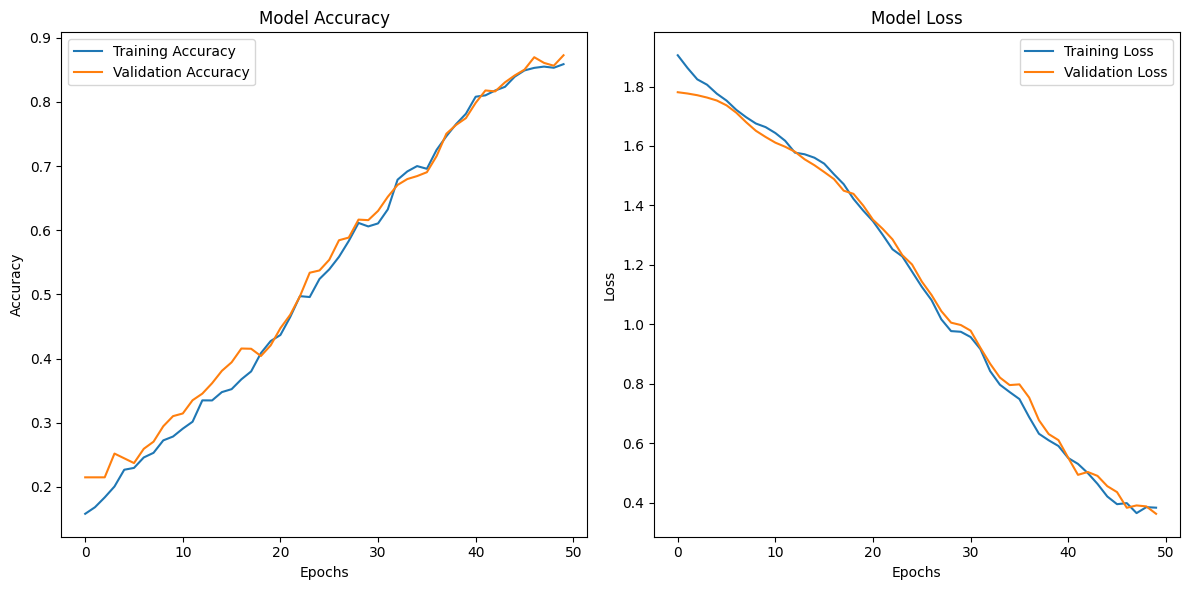

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


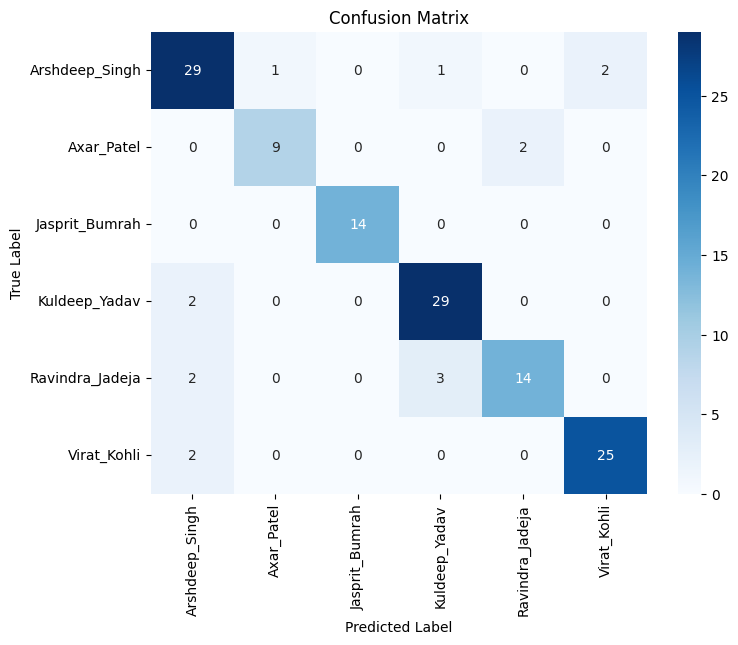

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.83      0.88      0.85        33
     Axar_Patel       0.90      0.82      0.86        11
 Jasprit_Bumrah       1.00      1.00      1.00        14
  Kuldeep_Yadav       0.88      0.94      0.91        31
Ravindra_Jadeja       0.88      0.74      0.80        19
    Virat_Kohli       0.93      0.93      0.93        27

       accuracy                           0.89       135
      macro avg       0.90      0.88      0.89       135
   weighted avg       0.89      0.89      0.89       135



In [281]:
# Example Usage:
output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
net, output_layers = load_yolo()  # Load YOLO model
features, labels, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers)  # Load and preprocess data

sequence_length = 10  # Define the sequence length (number of frames per sequence)

# Prepare the LSTM data (features grouped into sequences)
lstm_sequences, lstm_labels = prepare_lstm_data(features, labels, sequence_length)

print(f"Extracted features shape: {features.shape}")
print(f"Number of labels: {len(labels)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lstm_sequences, lstm_labels, test_size=0.2, random_state=42)

# Each sequence now has multiple features
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Initialize the model
num_features = X_train.shape[2]  # Automatically detect the number of features (step length, velocity, angles, etc.)
num_classes = len(encoder.classes_)  # Number of players
lstm_model = build_lstm_model(sequence_length, num_features, num_classes)

# Add early stopping to the training process
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), 
                         callbacks=[early_stopping])
                         
# Evaluate the model
train_loss, train_acc = lstm_model.evaluate(X_train, y_train)
print(f"Train accuracy: {train_acc}")
test_loss, test_acc = lstm_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Plot training history (accuracy and loss)
plot_training_history(history)

# Make predictions
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_classes, encoder.classes_)

# Print classification report
print_classification_report(y_test, y_pred_classes, encoder.classes_)